In [12]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Saddles

In [13]:
crytical_type_colors_dict = {'min': 'lime', 'max': 'red', 'saddle': 'yellow', 'regular': 'lightgrey'}

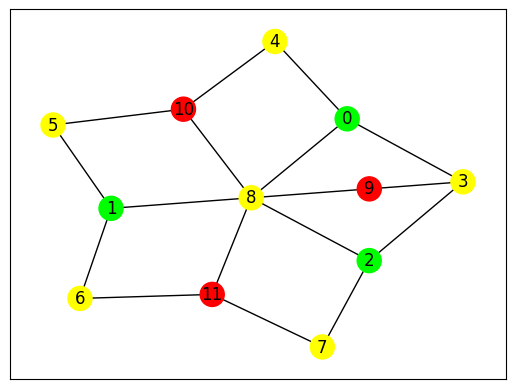

In [14]:
graph = nx.MultiGraph()
graph.add_nodes_from(range(3), critical_type='min')
graph.add_nodes_from(range(3, 9), critical_type='saddle')
graph.add_nodes_from(range(9, 12), critical_type='max')

edges = [(0, 3), (0, 4), (0, 8),
         (1, 5), (1, 6), (1, 8),  
         (2, 3), (2, 7), (2, 8),
         (9, 3), (9, 8), 
         (10, 4), (10, 5), (10, 8), 
         (11, 6), (11, 7), (11, 8)
]

for e0, e1 in edges:
    graph.add_edge(e0, e1, path=[e0, e1])



node_colors = pd.DataFrame([data for node, data in graph.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values


nx.draw_networkx(graph, node_color=node_colors, pos=nx.kamada_kawai_layout(graph))

## Saddle Cancellation

__Input:__ $C_0, C_1$
1. $\{P_0\} = \text{Neighbors}(C_0)/\{C_1\}$
2. $P_1 = \argmax_{P_j\in \text{Neighbors}(C1)} f(P_j)$
3. $S = \{S_0, S_1\} = (\text{Neighbors}(P_0)\cap\text{Neighbors}(C_1)) \cap \text{Local Mins}$

__Algorithm:__
1. Create a path $P_0-C_0-C_1-P_1$ (or $C_0-C_1-P_1$)
2. Remove Node $C_0$ (with edges $P_0C_0$ and $P_1C_1$)
3. Remove Edges $(S_i, C1)$ for $S_i\in S $ (for default case $S= \{S_0, S_1\}$)
4. If $\text{degree}(C_1) == 1$ remove $C_1$ (saddle is not a monkey saddle)
5. Add an edge $P_0P_1$ with the path atribute $P_0-C_0-C_1-P_1$ (or $C_0-C_1-P_1$)

In [17]:
def make_cancellation(graph: nx.MultiGraph, values, node0, node1=None):
    """
    Makes the cancellation of birth-death pair in the paths graph.

    Pramaters:
    ----------
    graph: nx.MultiGraph
        Multigraph
        Nodes should have 'critical_type' attribute with values: 'max', 'min' or 'saddle'.
        This function should be sed in the mothod MorseSmale.get_paths_graph, and also applyable to the resulting graph.

    values: array

    node0: int
        The index of the canceling vertex.
        This expect to be local maxima or minima and the coresponding node in the graph expect to have degree 1 or 2.

    node1: int
        The index of the saddle, paired with canceling vertex

    """
    if (graph.degree(node0) not in [1, 2]) or (graph.nodes[node0].get('critical_type') not in ['min', 'max']):
        raise ValueError('node0 expect to be an index of local maxima or minima degree 1 or 2.')
    if node1 is None:
        neighbors = list(graph.neighbors(node0))
        neighbors_vals = np.array([values[node] for node in neighbors])
        node1 = neighbors[np.argmin(abs(neighbors_vals - values[node0]))]
    if graph.nodes[node1].get('critical_type') != 'saddle':
        raise ValueError('node1 expect to be an index of saddle')
    
    pass